Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 0.214028522
Epoch: 0002 cost= 0.169849440
Epoch: 0003 cost= 0.151355639
Epoch: 0004 cost= 0.144290164
Epoch: 0005 cost= 0.137240350
Epoch: 0006 cost= 0.131305128
Epoch: 0007 cost= 0.128693148
Epoch: 0008 cost= 0.127187505
Epoch: 0009 cost= 0.123200916
Epoch: 0010 cost= 0.119026802
Epoch: 0011 cost= 0.115730248
Epoch: 0012 cost= 0.109891549
Epoch: 0013 cost= 0.107619949
Epoch: 0014 cost= 0.110526510
Epoch: 0015 cost= 0.108469367
Epoch: 0016 cost= 0.106280744
Epoch: 0017 cost= 0.106451936
Epoch: 0018 cost= 0.104985654
Epoch: 0019 cost= 0.100953609
Epo

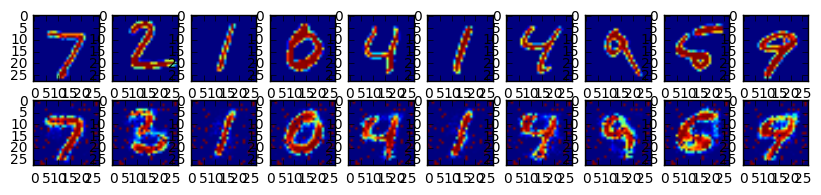

In [1]:
'''
Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.

2016 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu)


Original AutoEncoder example from:
Using an AutoEncoder on MNIST handwritten digits.

References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
    [TensorFlow AutoEncoder] https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py
'''

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# MNIST adatok betöltése
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

# hálózat tanítási paraméterek
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# rejtett rétegek száma
n_hidden_1 = 256 # 1. (és 3.) rejtett réteg
n_hidden_2 = 128 # 2. rejtett réteg ('bottleneck')
n_input = 784 # MNIST adatok mérete (kép: 28*28)

# tf bemenet (csak képek)
X = tf.placeholder("float", [None, n_input])

# súlyok és bias
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# encoder rész, szigmoid aktivációs függvénnyel
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# decoder rész, szigmoid aktivációs függvénnyel
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# modell összerakása
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# predikció
y_pred = decoder_op
# bemenet visszarakása a kimenetre
y_true = X

# loss, optimizer, MSE
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# változók inicializálása
init = tf.initialize_all_variables()

# ne foglalja le az összes GPU memóriát
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 

with tf.Session(config=config) as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # tanítási ciklus
    for epoch in range(training_epochs):
        # batch-ek
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # optimalizálás és költség számítás
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # minden epoch után log kiírása
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Encode és decode lépés a teszt halmazon
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Az eredeti és a visszaállított képek összehasonlítása
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()